## Is it a bee?

In [1]:
#code for kaggle
#import socket,warnings
#try:
#    socket.setdefaulttimeout(1)
#    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
#except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [1]:
#code for kaggle
#import os
#iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

#if iskaggle:
#    !pip install -Uqq fastai duckduckgo_search

The basic steps are:

1. Use DuckDuckGo to search for images of "bee photos"
1. Use DuckDuckGo to search for images of "wasp photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bee and a picture of a wasp and see if it works.

## Step 1: Download images of bees and wasps

In [2]:

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

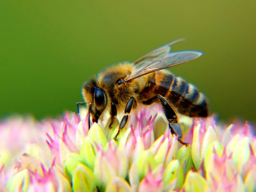

In [5]:
from fastdownload import download_url
dest = 'bee.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'wasp photos'


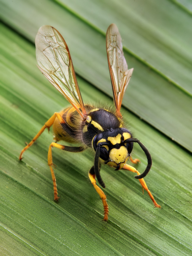

In [6]:
download_url(search_images('wasp photos', max_images=1)[0], 'wasp.jpg', show_progress=False)
Image.open('wasp.jpg').to_thumb(256,256)

In [7]:
searches = 'wasp','bee'
path = Path('bee_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'wasp photo'
Searching for 'wasp sun photo'
Searching for 'wasp shade photo'
Searching for 'bee photo'
Searching for 'bee sun photo'
Searching for 'bee shade photo'


## Step 2: Train the model

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

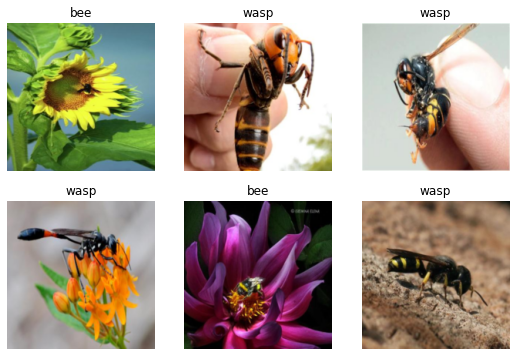

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   #what kind of input? what kind of output?
    get_items=get_image_files,     #use this function to get images
    splitter=RandomSplitter(valid_pct=0.2, seed=42),    #testing and validation set split
    get_y=parent_label,            #function to return parent folder from "forest" or "bird" folder
    item_tfms=[Resize(192, method='squish')]        #puts them into same size
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/YumaryVasquez/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.117508,0.298775,0.125000,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.417717,0.253880,0.062500,00:17
1,0.249360,0.298553,0.062500,00:18
2,0.204275,0.299778,0.062500,00:18


## Step 3: Use the model

In [11]:
is_bee,_,probs = learn.predict(PILImage.create('bee.jpg'))
print(f"This is a: {is_bee}.")
print(f"Probability it's a bee: {probs[0]:.4f}")

This is a: bee.
Probability it's a bee: 0.9952


In [12]:
is_bee,_,probs = learn.predict(PILImage.create('wasp.jpg'))
print(f"This is a: {is_bee}.")
print(f"Probability it's a bee: {probs[0]:.4f}")

This is a: wasp.
Probability it's a bee: 0.0000
